# Отток клиентов


Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import product
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Признаки
RowNumber — индекс строки в данных
CustomerId — уникальный идентификатор клиента
Surname — фамилия
CreditScore — кредитный рейтинг
Geography — страна проживания
Gender — пол
Age — возраст
Tenure — сколько лет человек является клиентом банка
Balance — баланс на счёте
NumOfProducts — количество продуктов банка, используемых клиентом
HasCrCard — наличие кредитной карты
IsActiveMember — активность клиента
EstimatedSalary — предполагаемая зарплата

Целевой признак

Exited — факт ухода клиента

In [4]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


готово

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Оценка размера объектов положительного класса

In [6]:
sum(data['Exited']/len(data))

0.20369999999999389

Оценка размера объектов отрицательного класса

In [7]:
1 - sum(data['Exited']/len(data))

0.7963000000000061

С целью избавиться в дальнейшем от ошибки несовместимости типов данных выполним :

In [9]:
data['Tenure'].median()

5.0

In [10]:
data['Tenure'] = data['Tenure'].fillna(5)

In [76]:
# далее будем работать с новым датафреймом data_df
data_df = data.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [12]:
data_df.duplicated().sum()

0

In [13]:
data_df.shape

(10000, 11)

Реализуем технику Onehot encoding из sklearn.preprocessing

In [14]:
data_df = pd.get_dummies(data_df, drop_first = True)
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [15]:
data_df.shape

(10000, 12)

получили в новом датафрейме уже 12 столбцов. теперь разделим на признаки и на целевой признак

In [16]:
features = data_df.drop("Exited", axis = 1)
target = data_df["Exited"]

In [17]:
features.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0


In [18]:
target.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [ ]:
#gender_one_hot = pd.get_dummies(data["Gender"], drop_first = True)
#country_one_hot = pd.get_dummies(data["Geography"], drop_first = True)

In [ ]:
#data.drop(["Gender", "Geography"], axis = 1, inplace = True)
#data_one_hot = pd.concat([data, gender_one_hot, country_one_hot], axis = 1)

In [ ]:
#data_one_hot

сформируем 3 выборки - обучающую (60% для обучения модели), валидационную (20% для поиска оптимальных параметрови лучшего алгоритма) и тестовую (20% для финальног теста выбьранной лучшей модели). для начала оформим валидационную выборку

In [19]:
features_train, features_validtest, target_train, target_validtest = train_test_split(features, target, 
                                                                              train_size = 0.6, 
                                                                              random_state = 12345,
                                                                              stratify = target)

In [20]:
print('Признаки обучающей выборки:',features_train.shape,  
      'Целевой признак обучающей выборки:', target_train.shape, 
      'Валидационная и тестовая вместе', features_validtest.shape, target_validtest.shape)

Признаки обучающей выборки: (6000, 11) Целевой признак обучающей выборки: (6000,) Валидационная и тестовая вместе (4000, 11) (4000,)


теперь поделим то что осталось (40%) на 2 равные части - соответсвенно валидационную и тестовую

In [21]:
features_valid, features_test, target_valid, target_test = train_test_split(features_validtest,
                                                    target_validtest,
                                                    train_size = 0.5,
                                                    random_state = 12345, 
                                                    stratify = target_validtest)

In [22]:
print(features_valid.shape, target_valid.shape, features_test.shape, target_test.shape)

(2000, 11) (2000,) (2000, 11) (2000,)


что в итоге получено - обучающая выборка (features_train, target_train); валидационная выборка (feautures_valid, target_valid); тестовая выборка (features_test, target_test)

In [23]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2837,549,49,6.0,124829.16,1,0,1,93551.36,1,0,0
9925,694,38,5.0,195926.39,1,1,1,85522.84,0,0,0
8746,660,34,8.0,106486.66,2,0,1,182262.66,0,0,1
660,632,41,5.0,81877.38,1,1,1,33642.21,1,0,0
3610,580,56,1.0,131368.30,1,1,0,106918.67,0,0,0


In [24]:
# Сформируем численные признаки
numeric_features = ['Age', 'Tenure', 'Balance', 'NumOfProducts', 'CreditScore', 'EstimatedSalary']

Реализуем технику scaling

In [25]:
# Создание объекта и настройка на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train[numeric_features])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [26]:
# Применяем метод transform к обучающей выборке
features_train[numeric_features] = scaler.transform(features_train[numeric_features])
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2837,-1.040434,0.953312,0.360600,0.774657,-0.914708,0,1,-0.119110,1,0,0
9925,0.454006,-0.095244,-0.002786,1.910540,-0.914708,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,1.087371,0.481608,0.820981,0,1,1.422836,0,0,1
660,-0.184996,0.190726,-0.002786,0.088439,-0.914708,1,1,-1.160427,1,0,0
3610,-0.720933,1.620574,-1.456328,0.879129,-0.914708,1,0,0.113236,0,0,0


In [27]:
# Применяем метод transform к валидационной выборке
features_valid[numeric_features] = scaler.transform(features_valid[numeric_features])
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6612,-1.524838,2.383160,-0.729557,1.011655,-0.914708,0,1,0.010275,0,0,0
519,0.587990,1.811221,0.360600,0.213192,-0.914708,0,1,0.453089,0,0,1
1609,-0.318980,-0.381213,1.087371,0.893896,-0.914708,1,0,-0.603508,0,0,0
3475,1.226991,-0.762506,-0.366172,-0.240363,0.820981,1,1,-1.621460,0,0,1
2707,-0.133464,-0.095244,-0.729557,0.447305,-0.914708,0,0,0.338574,0,0,0


In [28]:
# Применяем метод transform к тестовой выборке
features_test[numeric_features] = scaler.transform(features_test[numeric_features])
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
657,-0.504497,1.429928,-1.456328,0.873883,0.820981,1,1,1.725255,1,0,0
2083,-1.195031,-1.429769,-1.456328,-1.219673,-0.914708,1,1,1.203665,0,0,1
3234,-1.267176,0.762665,-1.456328,-1.219673,-0.914708,1,0,-1.374743,0,0,1
1551,0.825039,1.239281,0.723985,-1.219673,0.820981,0,1,0.382306,0,1,0
2344,0.660135,0.953312,-0.366172,0.267087,-0.914708,1,0,-1.613578,1,0,0


Теперь получены признаки для всех трех выборок. 

## Исследование задачи

In [ ]:
#data_one_hot_scaled = data_one_hot.copy(deep = True)
#data_one_hot_scaled[["Balance", "EstimatedSalary"]] = scaler.fit_transform(data_one_hot_scaled[["Balance", "EstimatedSalary"]])

In [ ]:
#data_one_hot_scaled

Посмотрим где есть пропуски в data_one_hot_scaled

In [ ]:
#data_one_hot_scaled.isna().sum()

In [29]:
data_df.isna().sum()

CreditScore          0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Geography_Germany    0
Geography_Spain      0
Gender_Male          0
dtype: int64

In [77]:
# Создадим функцию для выявления точности моделей
def acc_models(features_train, target_train, features_valid, target_valid):
    model_DTC = DecisionTreeClassifier(random_state = 12345)
    DTC_score = model_DTC.fit(features_train, target_train).score(features_valid, target_valid)
    
    model_RFC = RandomForestClassifier(random_state = 12345, n_estimators = 100)
    RFC_score = model_RFC.fit(features_train, target_train).score(features_valid, target_valid)
    
    model_LGR = LogisticRegression(solver = 'liblinear')
    LGR_score = model_LGR.fit(features_train, target_train).score(features_valid, target_valid)
    print("Точность:" "дерево решений", DTC_score, "случайный лес ", RFC_score, "логистическая регрессия", LGR_score)

In [78]:
acc_models(features_train, target_train, features_valid, target_valid)

Точность:дерево решений 0.793 случайный лес  0.8685 логистическая регрессия 0.811


посмтортим на баланс классов выборки

In [34]:
target_train.value_counts(normalize = 1)

0    0.796333
1    0.203667
Name: Exited, dtype: float64

In [53]:
target_train.shape

(6000,)

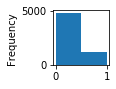

In [55]:
target_train.plot(kind ='hist', bins = 2, figsize = (1,1))

In [33]:
target_valid.value_counts(normalize = 1)

0    0.796
1    0.204
Name: Exited, dtype: float64

видим сущесвтенный дисбаланс классов. 

In [79]:
# Создадим функцию для расчета коэффициентов адекватности моделей
def models_ratio(features_train, target_train, features_valid, target_valid):
    model_DTC = DecisionTreeClassifier(random_state = 12345)
    model_DTC.fit(features_train, target_train)
    DTC_share = pd.Series(model_DTC.predict(features_valid)).value_counts(normalize = 1)
    
    
    
    model_RFC = RandomForestClassifier(random_state = 12345, n_estimators = 100)
    model_RFC.fit(features_train, target_train)
    RFC_share = pd.Series(model_RFC.predict(features_valid)).value_counts(normalize = 1)
    
    model_LGR = LogisticRegression(solver = 'liblinear')
    model_LGR.fit(features_train, target_train)
    LGR_share = pd.Series(model_LGR.predict(features_valid)).value_counts(normalize = 1)
    

    
    print("Доли ответов:" "дерево решений", DTC_share, "случайный лес ", RFC_share, "логистическая регрессия", LGR_share , end='')

In [80]:
models_ratio(features_train, target_train, features_valid, target_valid)

Доли ответов:дерево решений 0    0.787
1    0.213
dtype: float64 случайный лес  0    0.8645
1    0.1355
dtype: float64 логистическая регрессия 0    0.931
1    0.069
dtype: float64

среди всех вариантов самая высокая точность у логистической регрессии (хотя она выдает 0). создадим модель-константу (в качестве константы примем значение 0) для сравнения качества предсказаний

In [37]:
target_predict_constant = pd.Series([0]*len(target_valid))
target_predict_constant.shape

(2000,)

In [38]:
accuracy_score_constant = accuracy_score(target_valid, target_predict_constant)
accuracy_score_constant

0.796

так как по-прежнему есть проблема с дисбалансом классов, ни одна модель не показала результат > чем модель-константа.рассмотрим матрицу ошибок

In [39]:
model_DTC = DecisionTreeClassifier(random_state = 12345)
model_DTC.fit(features_train, target_train)
DTC_prediction = model_DTC.predict(features_valid)
confusion_matrix(target_valid, DTC_prediction)

array([[1376,  216],
       [ 198,  210]])

In [41]:
# Создадим функцию для расчета и вывода данных по полноте, точности и др метрик
def all_scores(target_valid, prediction):
    print("Полнота" , recall_score(target_valid, prediction))
    print("Точность", precision_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))
    print("AUC-ROC", roc_auc_score(target_valid, prediction))

In [42]:
all_scores(target_valid, DTC_prediction)

Полнота 0.5147058823529411
Точность 0.49295774647887325
F1-мера 0.5035971223021583
AUC-ROC 0.6895137451965709


достаточно низкое качество модели (значение f1-меры всего 0.5). рассмотрим матрицу ошибок для модели случайного леса

In [43]:
model_RFC = RandomForestClassifier(random_state = 12345, n_estimators = 100)
model_RFC.fit(features_train, target_train)
RFC_prediction = model_RFC.predict(features_valid)
confusion_matrix(target_valid, RFC_prediction)

array([[1529,   63],
       [ 200,  208]])

In [44]:
all_scores(target_valid, RFC_prediction)

Полнота 0.5098039215686274
Точность 0.7675276752767528
F1-мера 0.6126656848306332
AUC-ROC 0.7351155286235097


f1-мера по-прежнему имеет низкое значение. рассмотрим матрицу ошибок для модели логистической регрессии

In [45]:
model_LGR = LogisticRegression(solver = 'liblinear')
model_LGR.fit(features_train, target_train)
LGR_prediction = model_LGR.predict(features_valid)
confusion_matrix(target_valid, LGR_prediction)

array([[1538,   54],
       [ 324,   84]])

In [48]:
LGR_probabilities_one_valid = model_LGR.predict_proba(features_valid)[:, 1]
auc_roc_LGR = roc_auc_score(target_valid, LGR_probabilities_one_valid)
auc_roc_LGR

0.7875052345058627

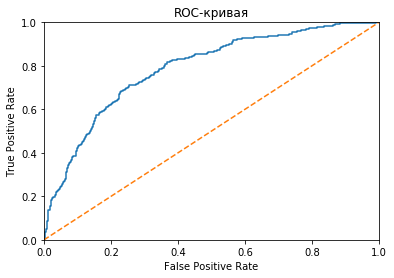

In [52]:
fpr, tpr, thresholds = roc_curve(target_valid, LGR_probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [ ]:
#features = data_one_hot_scaled.drop("Exited", axis = 1)
#target = data["Exited"]

In [ ]:
#features['Tenure'].median()

In [ ]:
#features.fillna(5, inplace = True)

Разделим данные на обчающую, валидационную и тестовую выборки

Обучим модели, начав с Logistic regression

Перейдем к обучению Random Forest

## Борьба с дисбалансом

Для получепния баланса между классами необходимо увеличить количество положительных ответов в 4 раза. Сбалансируем классы путем увеличения числа наблюдений положительного класса реализуя технику Upsampling

In [56]:
def upsample(features, target, repeat, upsampled_сlass):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if upsampled_сlass == 0:
        features_upsampled = pd.concat([features_zeros]* repeat + [features_ones] )
        target_upsampled = pd.concat([target_zeros]* repeat + [target_ones] )
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state = 12345)
        
    elif upsampled_сlass == 1:
        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state = 12345)
    else:
        features_upsampled = 0
        target_upsampled = 0  
        
        
       
    return features_upsampled, target_upsampled
    "Функция принимаем значение признаков (features[]), целевого признака (target[]), repeat(int / float), "
    " класс который будет увеличен (upsampled_сlass (0 or 1))"

In [57]:
# Тест функции
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 0)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

0    0.939904
1    0.060096
Name: Exited, dtype: float64
(20334,)


In [58]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 3)
features_train_upsampled

0

In [59]:
# увеличим количество положительных ответов в 4 раза, применяя функцию upsample 
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 1)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

1    0.50569
0    0.49431
Name: Exited, dtype: float64
(9666,)


Получено сбалансированное число классов

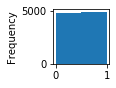

In [60]:
target_train_upsampled.plot(kind ='hist', bins=2, figsize=(1,1))

перейдем к обучению моделей на уже сбалансированной выборке

In [81]:
acc_models(features_train, target_train, features_valid, target_valid)

Точность:дерево решений 0.793 случайный лес  0.8685 логистическая регрессия 0.811


In [62]:
acc_models(features_train_upsampled, target_train_upsampled, features_valid, target_valid)

Точность:дерево решений 0.8075 случайный лес  0.862 логистческая регрессия 0.7255


точность приблизительно та же, рассмотрим теперь качество

In [63]:
model_DTC_upsampled = DecisionTreeClassifier(random_state = 12345)
model_DTC_upsampled.fit(features_train_upsampled, target_train_upsampled)
DTC_prediction_upsampled = model_DTC_upsampled.predict(features_valid)
all_scores(target_valid, DTC_prediction_upsampled)

Полнота 0.5245098039215687
Точность 0.5257985257985258
F1-мера 0.5251533742331288
AUC-ROC 0.701639324071337


In [64]:
model_RFC_upsampled = RandomForestClassifier(random_state = 12345, n_estimators = 100)
model_RFC_upsampled.fit(features_train_upsampled, target_train_upsampled)
RFC_prediction_upsampled = model_RFC_upsampled.predict(features_valid)
all_scores(target_valid, RFC_prediction_upsampled)

Полнота 0.5906862745098039
Точность 0.6885714285714286
F1-мера 0.6358839050131926
AUC-ROC 0.7611094689131934


In [65]:
model_LGR_upsampled = LogisticRegression(solver = 'liblinear')
model_LGR_upsampled.fit(features_train_upsampled, target_train_upsampled)
LGR_prediction_upsampled = model_LGR_upsampled.predict(features_valid)
all_scores(target_valid, LGR_prediction_upsampled)

Полнота 0.7426470588235294
Точность 0.40562248995983935
F1-мера 0.5246753246753246
AUC-ROC 0.7318762932308602


наблюдается улучшение показателей длявсех моделей, при этом лучшие результаты у модели случайного леса. изменим параметры для большего улучшения моделей

In [67]:
def RFQ(features_train, target_train, features_valid, target_valid):    
    
    bootstrap = [True, False]
    class_weight = ['balanced', 'balanced_subsample', None]
    max_features = ['auto', 'sqrt', 'log2'] 
    max_depth = [] 
    for i in range(1, 20):
        max_depth.append(i)

    myproduct = product(bootstrap, class_weight, max_features, max_depth)
    
    bootstrap_table = []
    class_weight_table = []
    features_table = []
    depth_table = []
    f1_table = []
    recall_table = []
    precision_table = []
    score_train_table = []
    score_valid_table = []
    
    for p in tqdm.tqdm(myproduct,):
        model_forest = RandomForestClassifier(
            bootstrap=p[0] , class_weight= p[1], max_features = p[2], max_depth = p[3], 
            n_estimators = 10, random_state = 12345)
        model_forest.fit(features_train, target_train)
        prediction = model_forest.predict(features_valid)         
        
        f1 = f1_score(target_valid, prediction)
        recall = recall_score(target_valid, prediction)
        precision = precision_score(target_valid, prediction)
        score_train = model_forest.score(features_train, target_train)
        score_valid = model_forest.score(features_valid, target_valid)        
        
        bootstrap_table.append(p[0])
        class_weight_table.append(p[1])
        features_table.append(p[2])
        depth_table.append(p[3])
        
        f1_table.append(f1)
        recall_table.append(recall)
        precision_table.append(precision)
        score_train_table.append(score_train)
        score_valid_table.append(score_valid)             
    
    
    quality_table = pd.DataFrame(data = (
        bootstrap_table, class_weight_table, features_table, depth_table, 
        f1_table, recall_table, precision_table, score_train_table, score_valid_table)).T
    quality_table.columns = (
        'bootstrap', 'class_weight', 'max_features', 'max_depth', 'f1', 'recall', 'precision', 'score_train', 'score_valid')
    return quality_table

    "4 параметра: features_train, target_train — признаки и целевой признак обучающей выборки"
    "features_valid, target_valid — признаки и целевой признак обучающей выборки"

In [68]:
quality_table = RFQ(features_train_upsampled, target_train_upsampled, features_valid, target_valid)

342it [00:36,  9.35it/s]


In [69]:
quality_table.query('score_valid>=score_train').sort_values('f1', ascending = False).head()

,bootstrap,class_weight,max_features,max_depth,f1,recall,precision,score_train,score_valid
177,False,balanced,auto,7,0.624872,0.745098,0.538053,0.812125,0.8175
196,False,balanced,sqrt,7,0.624872,0.745098,0.538053,0.812125,0.8175
272,False,balanced_subsample,log2,7,0.624872,0.745098,0.538053,0.812125,0.8175
253,False,balanced_subsample,sqrt,7,0.624872,0.745098,0.538053,0.812125,0.8175
234,False,balanced_subsample,auto,7,0.624872,0.745098,0.538053,0.812125,0.8175


лучшие параметры модели получились у случайного леса с глубиной = 7 и количсетвом оценок = 10

In [ ]:
#features_upsampled_train, target_upsampled_train = upsample(features_train, target_train, repeat = 4)

In [ ]:
#cv_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, scoring = 'f1', cv = 5)
#cv_rfc.fit(features_upsampled_train, target_upsampled_train)

In [70]:
model_RFC_final = RandomForestClassifier(
    bootstrap = True, class_weight = 'balanced', max_depth= 7,  n_estimators = 100, random_state = 12345)
model_RFC_final.fit(features_train_upsampled, target_train_upsampled)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

In [71]:
model_RFC_final_prediction = model_RFC_final.predict(features_valid)
rec_prec_f1(target_valid, model_RFC_final_prediction)

Полнота 0.7573529411764706
Точность 0.5459363957597173
F1-мера 0.6344969199178645
AUC-ROC 0.7979603901862252


In [72]:
target_predict_constant = pd.Series([0]*len(target_valid))
target_predict_constant.value_counts()

0    2000
dtype: int64

In [73]:
print('accuracy_score константой модели:', accuracy_score(target_valid, target_predict_constant))
print('accuracy_score финальной модели:', accuracy_score(target_valid, model_RFC_final_prediction))
print('AUC-ROC константой модели:', roc_auc_score(target_valid, target_predict_constant))
print('AUC-ROC финальной модели:', roc_auc_score(target_valid, model_RFC_final_prediction))

accuracy_score константой модели: 0.796
accuracy_score финальной модели: 0.822
AUC-ROC константой модели: 0.5
AUC-ROC финальной модели: 0.7979603901862252


В данном случае у финальной модели результаты лучше чем у модели-константы

In [ ]:
#predictions = cv_rfc.best_estimator_.predict(features_valid)
#print("Accuracy:", accuracy_score(predictions, target_valid))
#print("F1:", f1_score(predictions, target_valid))

## Тестирование модели

Сделаем прроверку на тестовой выборке

In [ ]:
#predictions = cv_rfc.best_estimator_.predict(features_test)
#print("Accuracy:", accuracy_score(predictions, target_test))
#print("F1:", f1_score(predictions, target_test))

In [74]:
model_RFC_final
model_RFC_final_prediction = model_RFC_final.predict(features_test)
rec_prec_f1(target_test, model_RFC_final_prediction)

Полнота 0.714987714987715
Точность 0.5196428571428572
F1-мера 0.6018614270941055
AUC-ROC 0.7730619679772223


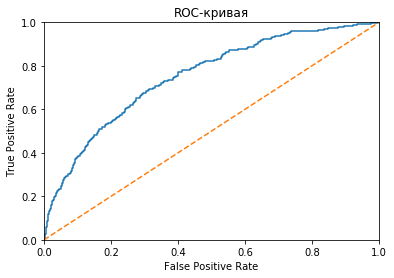

In [75]:
final_model_probabilities_one = model_LGR.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, final_model_probabilities_one) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

F1- мера больше 0.59, значеие полноты 0.71 - значит с высокой вероятность будет пресказан уход клиента из банка. Точность при этом не очень высокая. По полученным результатам можно сказать что данная модель в состоянии лучше выявить клиентов, котореы могут уйти в ближайшем будущем (покрывается достаточно большое количество клиентов).

## Общий вывод

Проведен первичный анализ данных, выявлен дисбаланс классов, положительный к отрицательному в пропорции 1 к 4. Выполнена предобработка данных, использованы техники One_hot_encoding и sampling.  По показателю F1-меры у всех моделей была высокая степень ошибки. Дисбаланс классов устранен методом upsampling, то есть достигнут баланс классов в обучающей выборке. На новых данных были получены результаты лучше. Улучшение модели продолжали на модели случайного леса. Улучшение проходило путем выбора параметров с применением цикла.